In [1]:
#=
import Pkg
Pkg.add("Plots")
Pkg.add("Ipopt")
Pkg.add("LinearAlgebra")
Pkg.add("PolygonOps")
=#

### COM361 &mdash; Introdução a Otimização &mdash; 2022, Prof. Amit ###

# Otimização de Wifi #

#### Pedro Henrique de Jesus Teixeira (pedroteixeir@poli.ufrj.br), Diego Nunes Gonçalves Freitas (diegongfreitas@poli.ufrj.br)

*****

### Índice

1. [Introdução](#1.-Introdução)
1. [Modelo Matemático](#2.-Modelo Mathemático)
1. [Solução](#3.-Solução)
1. [Resultados e Discussão](#4.-Resultados-e-discussão)
  1. [Subseção Opcional](#4.A.-Acrescente-subseções-se-necessário)
1. [Conclusão](#5.-Conclusão)
1. [Referências bibliográficas] (#6.-Referências bibliográficas)

## 1. Introdução ##

O projeto a ser apresentado ao longo desse relatório consiste em um mecânismo de otimização do posicionamento de um roteador wifi em um estabelecimento ou residência. Faremos isso porcurando o melhor ponto de instalação de um roteador objetivando a maximização da força do sinal que chega aos dispositivos conectados. 

É muito comum perceber cômodos de sua casa em que o sinal wifi chega muito enfraquecido ou simplesmente não chega, chamaremos essas regiões de Zonas Mortas. Denominamos de Zonas Críticas os cômodos nos quais há um dispositivo conectado a rede. Além de maximizar o sinal em cada dispositivo conectado precisamos, também, eliminar a possibilidade de formação de Zonas Mortas em Zonas Críticas. A complexidade dos cenários de teste do nosso algoritmo cresce gradualmente, conforme aumentamos a planta do imóvel e adicionamos fontes de interferência como espelhos, madeira, móveis metálicos, etc. 

O primeiro padrão de conexão wifi surgiu em 1997. Com o passar dos anos essa tecnologia se popularizou e, nos dias atuais, quase todo estabelecimento ou residência possui uma rede de internet via Wifi. Com a expansão dessa tecnologia suas qualidades e defeitos foram ficando mais evidentes. Um dos mais evidentes defeitos é a grande dependência do funcionamento ótimo da rede ao posicionamento do roteador wifi. Se mal posicionado em uma residência, o roteador pode acabar entregando, aos seus dispositivos conectados, porcentagens incrivelmente pequenas do sinal original. 

Nosso projeto tratará sobre redes [WLAN](https://pt.wikipedia.org/wiki/Rede_de_área_local_sem_fio), ou seja, redes de area local sem fio que usam ondas de rádio para fazer a conexão entre os dispositivos. Para fins de simplificação, os dados relacionados à perda de sinal ao longo da distância e por meio de interferências foram sintetizados e previamente estabelecidos.

A partir desse ponto apresentaremos o desenvolvimento do projeto, começando pelo modelo matématico na seção 2. Em seguida, na seção 3, apresentamos nossa solução de otimização, desenvolvida em Julia 1.8.0, possível de ser rodada nesse notebook Jupyter. Na seção 4, evidenciamos nossos resultados para cada cenário, variando em graus de complexidade, através de plots simulando um ambiente de rede. Na seção 5, finalizamos a apresentação do projeto apresentando nossas conclusões acerca dos resultados obtidos e dos métodos utilizados, ressaltando aspectos passíveis de melhorias. Por fim, na seção 6, apresentamos as referencias biubliográficas utilizadas ao longo do desenvolvimento do projeto.

## 2. Modelo matemático ##
Para abordar melhor nosso problema representamos o ambiente do imóvel trabalhado como uma matriz $A_{mXn}$. Começaremos apresentando nossas variáveis
de decisão. 

Denominamos $C_{ij}$, um posição da matriz em que há um dispositivo conectado a rede, sendo $c$ o número de dispositivos.

Denominamos $R_{ij}$, uma posição da matriz em que há um roteador.

O valor registrado em cada posição da matriz determinará o que esta presente naquele local da forma:
$$
a_{ij} = 
\begin{cases}
2, \text{ caso haja um roteador naquele local}\\
1, \text{ caso haja um dispositivo conectato naquele local}\\
0, \text{ caso não haja nada relacionado a rede naquele local}
\end{cases}
$$

Sopomos então que, a distância $d$ entre um roteador e um dispositivo, dada por:
$$
d = R_{ij} - C_{ij}
$$
influencia linearmente na força $f_{ij}$ do sinal que chega ao dispositivo na posição ij, da seguinte forma.
$$
f_{ij} = 1 - 0.2d 
$$

Primeiramente a posição de cada dispositivo sera dada aleatoriamente na matriz. 

Nosso objetivo será encontrar a posição para o roteador que maximize a soma das forças do sinal em cada dispositivo. 

Além disso, evitaremos grandes variações para a força do sinal em cada dispositivo, limitando o desvio padrão entre eles, sendo esse denominado $\sigma_f$.

Exemplificando o posicionamento ótimo de um roteador para um caso simples:
$$
\begin{bmatrix}
  1 & 0 & 0 & 2 & 0 & 0 & 1\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

Dessa forma, nosso problema de otimização em forma padrão fica assim:
$$
\begin{aligned}
\underset{x \in \mathbb{R^n}}{\text{maximize}}\qquad& \sum_{k=0}^{c}{f_k(d)} \\
\text{sujeito a:}\qquad& \sigma_{f(d)} \le 0,4\\
& d > 0
\end{aligned}
$$

Vamos trabalhar ainda com casos em que há objetos no estabelecimento que causem interferência no sinal, gerando Zonas mortas. Para isso iremos alterar um pouco nosso cenário:

$$
a_{ij} = 
\begin{cases}
3, \text{ caso haja uma fonte de interferência naquele local}\\
2, \text{ caso haja um roteador naquele local}\\
1, \text{ caso haja um dispositivo conectato naquele local}\\
0, \text{ caso não haja nada relacionado a rede naquele local}
\end{cases}
$$

Exemplificando, agora, o posicionamento ótimo de um roteador para um caso com interferência:

Se mantivermos o roteador na mesma posição um dos dispositivos ficaria em uma zona morta
$$
\begin{bmatrix}
  1 & 0 & 0 & 2 & 3 & 0 & 1\\
  0 & 0 & 0 & 0 & 3 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$
Para solucionar esse problema o roteador deve ser movido de forma a alterar a região de Zona morta, da seguinte forma:
$$
\begin{bmatrix}
  1 & 0 & 0 & 0 & 3 & 0 & 1\\
  0 & 0 & 0 & 0 & 3 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 2 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

Isso encerra o modelo matemático do nosso projeto. Em seguida apresentaremos nossa solução.



## 3. Solução ##

Nesta seção, coloque seu código em Julia + JuMP e resolva o problema proposto. Seu código deve ser limpo (não macarrônico!), de fácil leitura, bem comentado e anotado e deve compilar sem erros em Julia 1.x, x $\geq 1$! Não valem códigos em outras linguagens. **Vou rodar seu código para avaliar seu projeto**. Sugiro a utilização de múltiplos blocos de códigos separados por blocos de texto (células Markdown) explicando as várias partes da sua solução. Sugiro também a resolução de várias versões do seu problema, com modelos e hipóteses diferentes.

É permitido chamar pacotes externos, mas evite a utilização de bibliotecas exóticas (pois, em geral, não rodam em todas as versões de Julia, e terei que instalar a mesma versão que você usou, ou rodar na plataforma Google Colab, que gostaria de evitar).

In [1]:
# Este nosso modelo matematico
using JuMP, Ipopt, Statistics, LinearAlgebra, PolygonOps

m = Model(Ipopt.Optimizer)
apartamento = zeros(4,4)
interferencias = false                                                  # esta é matriz que define o tamanho do apartamento
interferencias = [ [[0,2] , [1,2]]]                                     # posições bidimensionais das interferencias
dispositivos = [[0,0],[0,4]]                                            
decaimento = 0.2
alcance = 1/decaimento

function projection(x,y)
    for interferencia in interferencias
        u = [interferencia[1][1], interferencia[2][1]]
        v = [interferencia[1][2], interferencia[2][2]]
    
        candidatop1x_1 = x + alcance*(u[1]-x)/(sqrt((u[1]-x)^2+(v[1]-y)^2))
        candidatop1x_2 = x - alcance*(u[1]-x)/(sqrt((u[1]-x)^2+(v[1]-y)^2))
        
        if u[1]==x
            proj_1x = x
        elseif  u[1] < x 
            if candidatop1x_1 < u[1]
                proj_1x = candidatop1x_1
            else
                proj_1x = candidatop1x_2
            end 
        else
            if candidatop1x_1 > u[1]
                proj_1x = candidatop1x_1
            else
                proj_1x = candidatop1x_2
            end
        end
        proj_1y = y + ((proj_1x-x)*(v[1]-y))/(u[1]-x)
        proj_1 = [proj_1x,proj_1y]

        candidatop2x_1 = x + alcance*(u[2]-x)/(sqrt((u[2]-x)^2+(v[2]-y)^2))
        candidatop2x_2 = x - alcance*(u[2]-x)/(sqrt((u[2]-x)^2+(v[2]-y)^2))
        
        if u[2] == x
            proj_2x = x
        elseif  u[2] < x 
            if candidatop2x_1 < u[2]
                proj_2x = candidatop2x_1
            else
                proj_2x = candidatop2x_2
            end 
        else
            if candidatop2x_1 > u[2]
                proj_2x = candidatop2x_1
            else
                proj_2x = candidatop2x_2
            end
        end
        proj_2y = y + ((proj_2x-x)*(v[2]-y))/(u[2]-x)
        proj_2 = [proj_2x,proj_2y]
        return proj_1, proj_2
    end
end

function areClockwise(v1, v2) 
    return -v1[1]*v2[2] + v1[2]*v2[1] > 0         #verifica se um ponto esta no sentido horario de um vetor
end

function interference(x,y,x_dev,y_dev)
    for interferencia in interferencias
        proj_1, proj_2 = projection(x,y)          # calcula as projeções das interferencias no raio do circulo
        oa = [proj_1[1] - x, proj_1[2] - y ]      # faz o vetor entre o roteador e uma das projeções do circulo
        ob = [proj_2[1] - x,proj_2[2] - y ]       # faz o vetor entre o roteador e uma das projeções do circulo
        return !areClockwise(oa, [x_dev-x,y_dev-y]) && areClockwise(ob, [x_dev-x,y_dev-y]) 
    end
    return 0
end 

function force(x,y, std_dev)
    forca = []
    for i in dispositivos
        distancia = sqrt((x-i[1])^2+(y-i[2])^2)   # a distancia entre o roteador e os dispositivos ´pode ser calculado pela distancia euclidiana
        f_= 1.0-decaimento*distancia              # a forca do sinal definida pela funcao apresentada no modelo matematico
        if f_ < 0.0
            f_ = 0.0                              # não é possivel ter sinais negativos
        else
            if interference(x,y,i[1],i[2]) == 1 
                f_ = 0.0                          # a interferencia bloqueia 100% do sinal
            end
        end
        push!(forca,f_)
    end
    if std_dev == 1
        return Statistics.std(forca)           #calculo do desvio padrao
    elseif std_dev == -1
        return forca                           # retorna o vetor de intensidade dos sinais por dispositivo
    else
        return sum(forca)                      # retorna a soma da intensidade dos sinais
    end
end

register(m, :force, 3, force, autodiff=true)
@variable(m, 0 <= x <= size(apartamento)[1])              # as posições devem ser positivas
@variable(m, 0 <= y <= size(apartamento)[2])              # as posições devem ser positivas e os roteadores da matriz não podem ser posicionados fora dos limites do apartamento
@NLconstraint(m, force(x,y,1)<= 0.1)                      # o desvio padrao do vetor de sinais deve ser pequeno para garantir que nao tenha muita diferenca de sinal entre dispositivos
@NLobjective(m, Max, force(x,y,0))                        # queremos maximizar a soma do sinal de wifi

optimize!(m)

println("x =", JuMP.value.(x))     # imprime o resultado na tela
println("y =", JuMP.value.(y))     # imprime o resultado na tela


**Tenha certeza de que seu código compila corretamente! Rodarei seu código!**

## 4. Resultados e discussão ##

### 4.1 Area do apartamento ###
O Plot abaixo mostra a definição em azul da area do apartamento e segundo a legenda a posição dos dispositivos e do roteador, a reta é uma fonte de interferencia pela qual o sinal não atravessa, como um espelho ou móvel metálico

In [ ]:
using Plots
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
plot(rectangle(4,4,0,0), label="Apartamento", opacity=.2)
i=0
for dispositivo in dispositivos 
    scatter!([dispositivo[1]],[dispositivo[2]], label="Dispositivo "*string(i))
    i+=1
end
for interferencia in interferencias
    scatter!([interferencia[1][1],interferencia[2][1]],[interferencia[1][2],interferencia[2][2]],label="Interferencia")
    plot!([interferencia[1][1],interferencia[2][1]],[interferencia[1][2],interferencia[2][2]],label="Interferencia")
end
scatter!([JuMP.value.(x)],[JuMP.value.(y)], label="Roteador")

LoadError: UndefVarError: dispositivos not defined

### 4.2 - Valores dos sinais e desvio padrão ###
Abaixo apresentamos os valores dos sinais em cada dispositivo conectado e o desvio padrão. Vemos que nosso modelo de otimização atingiu o objetivo esperado, mantendo valores próximos e tendo todos os dispositivos conectados a rede, com a maior soma de sinal possível na configuração apresentada.

In [ ]:
println(force(JuMP.value.(x),JuMP.value.(y),-1))
println(force(JuMP.value.(x),JuMP.value.(y),1))

Any[0.5177819965202213, 0.5726354635502906]
0.03878725850855473


### 4.3 - Area de Interferência ###
O Plot abaixo define o raio de alcance do sinal e a zona morta gerada pela fonte de interferência. Conseguimos calcular essas áreas atraves do setor circular definido entre as linhas de interferência. Tais linhas sendo definidas desde o roteador até as projeções das extremidades da fonte de interferência na circunferência do sinal. A primeira vista, os dispositvos parecem estar no limite da zona de interferencia.

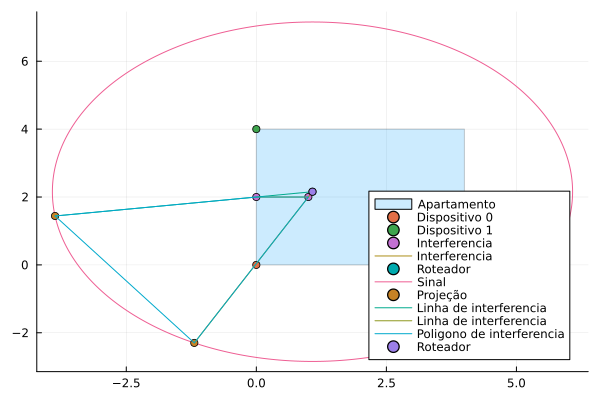

In [ ]:
using Plots
function circleShape(x,y,r)
    teta = LinRange(0,2*pi, 500)
    x .+ r*sin.(teta), y .+ r*cos.(teta)
end
plot!(circleShape(JuMP.value.(x),JuMP.value.(y),5),label="Sinal")
for interferencia in interferencias
    proj_1, proj_2 = projection(JuMP.value.(x),JuMP.value.(y))
    scatter!([proj_1[1],proj_2[1]],[proj_1[2],proj_2[2]],label="Projeção")
    plot!([JuMP.value.(x),proj_1[1]],[JuMP.value.(y),proj_1[2]], label="Linha de interferencia")
    plot!([JuMP.value.(x),proj_2[1]],[JuMP.value.(y),proj_2[2]], label="Linha de interferencia")
end
scatter!([JuMP.value.(x)],[JuMP.value.(y)], label="Roteador")

### 4.4 Visualização matématica da área de interferência ###
Através do código abaixo podemos verificar que, apesar da proximidade, os dispositivos realmente não se encontram dentro da area de interferencia, nem fora do circulo de sinal. O ponto encontrado foi, definitivamente, o melhor ponto possível.

In [ ]:
for i in dispositivos
    distancia = sqrt((JuMP.value.(x)-i[1])^2+(JuMP.value.(y)-i[2])^2) # a distancia entre o roteador e os dispositivos ´pode ser calculado pela distancia euclidiana
    f_= 1.0-decaimento*distancia                     # a forca do sinal definida pela funcao apresentada no modelo matematico
    if f_ < 0.0
        f_ = 0.0                              # não é possivel ter sinais negativos
        print("\n\nlonge")
        print(i)
    else
        if interference(JuMP.value.(x),JuMP.value.(y),i[1],i[2]) == 1 
            print("\n\ndentro do setor circular")
            print(i)
        end
    end
end

## 5. Conclusão ##

Finalizando, podemos perceber que nosso projeto levou ao desenvolvimento de um mecânismo muito útil, tanto para profissionais de rede, quanto para clientes de operadoras que buscam a configuração que lhes dará o melhor funcionamento da rede em seu imóvel. Conseguimos determinar o melhor posicionamento possível para um roteador em um estabelecimento, considerando casos com e sem interferências ao sinal.

Acreditamos que a direção à ser seguida para melhor desenvolvimento do trabalho seria a complexificar ainda mais nossos cenários. Até agora consideramos apenas fontes de interferência como barreiras metálicas e espelhos que barram o sinal, podemos, no futúro, levar em consideração interferências trazidas por outros sinais, como de aparelhos micro-ondas que atuam em bandas de frequências semelhantes aos de alguns roteadores, no caso de 2.4Ghz. Além disso podemos adicionar novos elementos como repetidores de sinais, dispositivos móveis conectados à rede, fazendo uma analise probabilista dos cômodos em que esses dispositivos se encontrariam na maior parte do tempo.

## 6. Referências bibliográficas ##

[Optimization Models and Methods for Planning Wireless Mesh Networks](https://www.researchgate.net/publication/220447584_Optimization_Models_and_Methods_for_Planning_Wireless_Mesh_Networks)

[Redes Mesh](https://blog.intelbras.com.br/o-que-e-rede-mesh-e-quais-suas-vantagens/)

[WLAN](https://pt.wikipedia.org/wiki/Rede_de_área_local_sem_fio)

## 7. Contribuições ##

Ideia - Diego Nunes

Modelo Matemático - Diego Nunes

### Solução ###

    Projeção - Diego Nunes

    Area de Interferencia - Pedro Henrique

    Calculo da Intensidade do Sinal - Pedro Henrique

### Resultados e Discussão ###

    Plots - Pedro Henrique 

Conclusão - Diego Nunes

Pesquisa - Diego Nunes e Pedro Henrique